In [33]:
import numpy as np
import scipy.optimize as op
import datetime
import emcee
import matplotlib.pyplot as plt
import corner
%matplotlib inline

In [2]:
mars = np.genfromtxt('harp_mars.dat', usecols=np.arange(0, 9))
jupiter = np.genfromtxt('harp_jupiter.dat', usecols=np.arange(0, 8))
uranus = np.genfromtxt('harp_uranus.dat', usecols=np.arange(0, 8))

In [18]:
mars_etamb = mars[:,5]
jupiter_etamb = jupiter[:,5]
uranus_etamb = uranus[:,5]

mars_dates = mars[:,0]
jupiter_dates = jupiter[:,0]
uranus_dates = uranus[:,0]

mars = mars[mars[:,1] > 5]
mars = mars[mars[:,1] < 19]
jupiter = jupiter[jupiter[:,1] > 5]
jupiter = jupiter[jupiter[:,1] < 19]
uranus = uranus[uranus[:,1] > 5]
uranus = uranus[uranus[:,1] < 19]

planets_etamb = np.concatenate((mars_etamb, jupiter_etamb, uranus_etamb), axis=0)
raw_dates = np.concatenate((mars_dates, jupiter_dates, uranus_dates), axis=0)
dates = [datetime.datetime.strptime(str(int(date)),'%Y%m%d') for date in raw_dates]
yerr = np.array([(.01 * etamb + .01) for etamb in planets_etamb])

In [19]:
oldest = min(dates)
days = np.array([np.float64((date - oldest).days) + 1 for date in dates])

In [20]:
m_true = 0.0
b_true = .5

f_true = .1

In [21]:
def lnlike(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2))

In [22]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true], args=(days, planets_etamb, yerr))
m_ml, b_ml = result["x"]

In [23]:
print(m_ml, b_ml)

5.85210190859e-06 0.505892708788


In [24]:
def lnprior(theta):
    m, b= theta
    if -1.0 < m < 1.0 and 0.0 < b < 1.0:
        return 0.0
    return -np.inf

In [25]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [26]:
ndim, nwalkers = 2, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [27]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(days, planets_etamb, yerr))

In [28]:
sampler.run_mcmc(pos, 500)

(array([[  5.83904466e-06,   5.05885777e-01],
        [  6.36974616e-06,   5.05110962e-01],
        [  5.93335879e-06,   5.04498875e-01],
        [  5.87144271e-06,   5.05998295e-01],
        [  5.26113197e-06,   5.06603320e-01],
        [  5.60831042e-06,   5.06832826e-01],
        [  6.33374831e-06,   5.05462018e-01],
        [  5.98451458e-06,   5.05600628e-01],
        [  6.03144335e-06,   5.06632505e-01],
        [  5.22302349e-06,   5.06566384e-01],
        [  6.80831007e-06,   5.04078391e-01],
        [  5.73312097e-06,   5.05164603e-01],
        [  5.55838955e-06,   5.05812551e-01],
        [  5.85116392e-06,   5.05133055e-01],
        [  7.81997552e-06,   5.03432818e-01],
        [  6.11334089e-06,   5.05616372e-01],
        [  6.51206583e-06,   5.05041099e-01],
        [  6.02678933e-06,   5.06451206e-01],
        [  6.01819130e-06,   5.05465930e-01],
        [  6.79700299e-06,   5.04811234e-01],
        [  5.40804442e-06,   5.06408708e-01],
        [  6.14801836e-06,   5.051

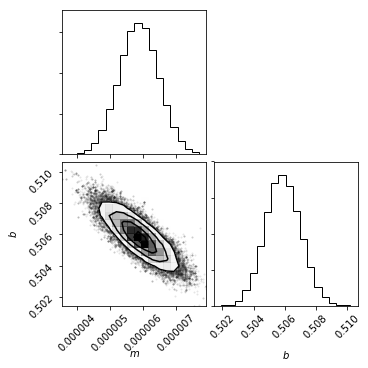

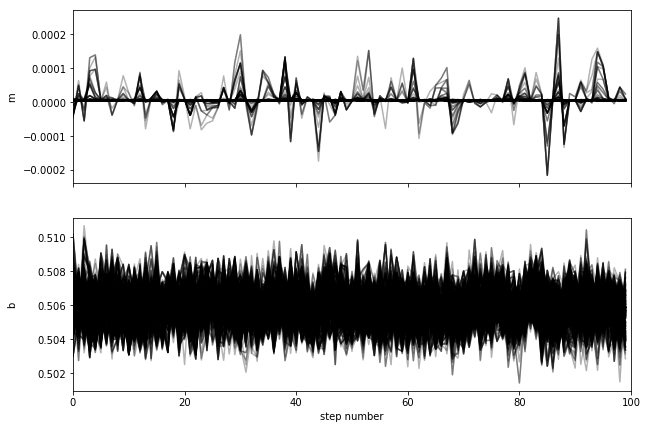

In [32]:
plt.figure(1)
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = ["m", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.show()

In [30]:
flat_samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

In [31]:
fig = corner.corner(flat_samples, labels=["$m$", "$b$"],
                      truths=[m_true, b_true])
fig.savefig("triangle.png")